# Anatomical receptive fields



For calculating the anatomical RF size, the main idea works like this. For a given neuron (e.g. Tm9):
<br> 
1. Get the center at a given layer. Visualize.
2. Select presynaptic parters IDs for the RF
3. Get all presynaptic sites as a cloud of point. Visualize.
4. From the cloud of point, calculate the volum.
5. Perfomr a 3D to 2D projection along the vector that goes from the medulla centroid to the neurons (e.g. Tm9) center.
6. Store the area and the total spatial offset in the dataset

Before that, we need to get the medulla centroid, and for that:

- This notebook tries to get the curvature of the medulla based on XYZ-center coordinates of a certain neuron type.
- Then, it gets the centroid as the center of a circunference which will fit the curvature of the medulla.



In [1]:
# Loading needed packages
#Importing packages
import navis
import fafbseg
from fafbseg import flywire
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import math 
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


## A ) Obtaining the medulla centroid based on the medulla curvature

### Loading point for the curvature

In [2]:
# Selecting a file with XYZ coordinates
dataPath = r'E:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230621'
fileName = f'Tm9 proofreadings_{date}.xlsx'
filePath = os.path.join(dataPath,fileName)

In [3]:
database_df = pd.read_excel(filePath)
#Some filtering
#Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
if database_df["seg_id"][0] == 'asdf': 
    database_df = database_df.iloc[1: , :]
    database_df.reset_index(inplace=True,drop=True)
#Selecting hemisphere
hemisphere_str = 'L'
database_df = database_df[database_df['hemisphere'] == hemisphere_str ].copy()

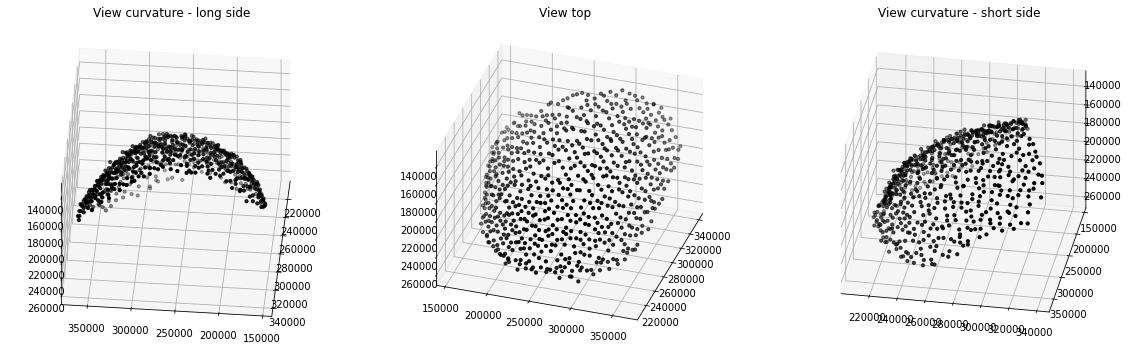

In [69]:
# Visualize the points and the curvature

#Which point? Add a filter if wished
root_ids = database_df['seg_id'] # No filter option


#Gettting the center point in specific neuropile from database
xyz_neuropil = 'XYZ-ME'
xyz_df = database_df[database_df['seg_id'].isin(root_ids)].copy()
xyz_pre = xyz_df[xyz_neuropil].tolist()
# Split each string by comma and convert the elements to floats
xyz_pre_arr = np.array([list(map(float, s.split(','))) for s in xyz_pre])

xyz_pre_arr_new = xyz_pre_arr * np.array([4,4,40])

#getting inffo for the plot
OL_R = flywire.get_neuropil_volumes(['ME_R']) #['ME_R','LO_R','LOP_R']


fig = plt.figure(figsize =(20,10))
# First subplot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(xyz_pre_arr_new[:, 0], xyz_pre_arr_new[:, 1], xyz_pre_arr_new[:, 2], s=10, c='k')
ax1.azim = -185  # (-18 view from top), (-185 view curvature)
ax1.elev = -140  # (-148 view from top, (-140 view curvature)
ax1.set_title('View curvature - long side')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(xyz_pre_arr_new[:, 0], xyz_pre_arr_new[:, 1], xyz_pre_arr_new[:, 2], s=10, c='k')
ax2.azim = -18  # (-18 view from top), (-185 view curvature)
ax2.elev = -148  # (-148 view from top, (-140 view curvature)
ax2.set_title('View top')

# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(xyz_pre_arr_new[:, 0], xyz_pre_arr_new[:, 1], xyz_pre_arr_new[:, 2], s=10, c='k')
ax3.azim = -100  # (-18 view from top), (-185 view curvature, -100 )
ax3.elev = 210  # (-148 view from top, (-140 view curvature, 210)
ax3.set_title('View curvature - short side')

plt.show()

In [71]:
OL_R = flywire.get_neuropil_volumes(['ME_R','LO_R','LOP_R']) # ['LOP_L', 'LOP_R'], ['LO_R'], ['ME_R']
navis.plot3d(OL_R)

In [60]:
# Find the sphere that matches the curvature based on these points

from scipy.optimize import least_squares

# Define the objective function for the sphere fitting
def sphere_residuals(params, x, y, z):
    cx, cy, cz, r = params
    return np.sqrt((x - cx) ** 2 + (y - cy) ** 2 + (z - cz) ** 2) - r

# Extract the XYZ coordinates from the cloud of points
x = xyz_pre_arr[:, 0] # xyz_pre_arr_new
y = xyz_pre_arr[:, 1] # xyz_pre_arr_new
z = xyz_pre_arr[:, 2] # xyz_pre_arr_new

# Initial guess for the sphere parameters (center and radius)
initial_params = [0, 0, 0, 1]

# Fit the sphere using least squares optimization
result = least_squares(sphere_residuals, initial_params, args=(x, y, z))

# Get the fitted sphere parameters
cx, cy, cz, r = result.x

print("Center coordinates (cx, cy, cz):", cx, cy, cz)
print("Radius (r):", r)


#Seb comment, the fit is not good enough yet!

Center coordinates (cx, cy, cz): -29283657.45041907 2670238.632222715 -378477316.8815695
Radius (r): 379627286.99567354


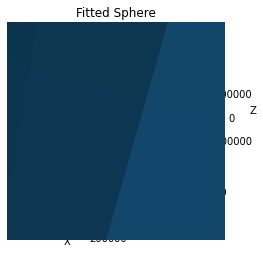

In [58]:
# Plotting the sphere and points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(xyz_pre_arr_new[:, 0], xyz_pre_arr_new[:, 1], xyz_pre_arr_new[:, 2], s=1, c='k')

# Generate points on the surface of the fitted sphere
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)
x_sphere = cx + r * np.sin(phi) * np.cos(theta)
y_sphere = cy + r * np.sin(phi) * np.sin(theta)
z_sphere = cz + r * np.cos(phi)

# Plot the fitted sphere
ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.5)

# Set plot limits
max_range = np.max(np.abs(xyz_pre_arr_new))
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Fitted Sphere')

# Show the plot
plt.show()